In [104]:
#documentation: https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import glob
import sys
import numpy as np
import parselmouth
import math
import matplotlib.pyplot as plt

In [105]:
import os

if os.getcwd().endswith("Calculator") == True or \
   os.getcwd().endswith("Calculator\\") == True or \
   os.getcwd().endswith("Calculator/") == True :
    cwd = os.getcwd()

print(cwd)

C:\Users\qan96\Documents\GitHub\Audio-Calculator


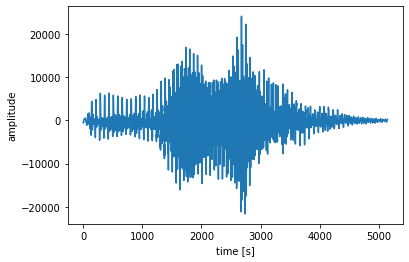

p
[1.94250194e-04 1.94250194e-04 0.00000000e+00 0.00000000e+00
 1.94250194e-04 1.94250194e-04 0.00000000e+00 1.94250194e-04
 0.00000000e+00 5.82750583e-04 0.00000000e+00 5.82750583e-04
 3.88500389e-04 5.82750583e-04 3.88500389e-04 3.88500389e-04
 7.77000777e-04 1.16550117e-03 2.33100233e-03 1.74825175e-03
 2.33100233e-03 1.35975136e-03 2.71950272e-03 3.88500389e-03
 3.10800311e-03 3.10800311e-03 3.88500389e-03 5.05050505e-03
 9.51825952e-03 0.00000000e+00 5.63325563e-03 6.60450660e-03
 5.05050505e-03 6.79875680e-03 7.38150738e-03 8.74125874e-03
 8.15850816e-03 1.49572650e-02 1.37917638e-02 1.70940171e-02
 2.35042735e-02 2.07847708e-02 2.62237762e-02 3.76845377e-02
 4.68142968e-02 6.09945610e-02 1.97358197e-01 0.00000000e+00
 1.05672106e-01 5.90520591e-02 3.86557887e-02 2.85547786e-02
 2.11732712e-02 1.78710179e-02 1.59285159e-02 1.45687646e-02
 2.19502720e-02 1.28205128e-02 1.18492618e-02 0.00000000e+00
 1.02952603e-02 1.16550117e-02 8.15850816e-03 8.15850816e-03
 8.15850816e-03 7.5757

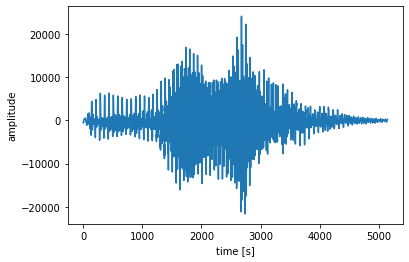

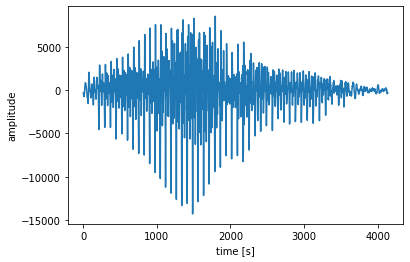

p
[0.00024166 0.         0.         0.00024166 0.00024166 0.00024166
 0.00024166 0.00048333 0.00024166 0.00024166 0.00048333 0.00048333
 0.         0.00048333 0.00048333 0.00120831 0.00072499 0.
 0.00048333 0.         0.00048333 0.00072499 0.00072499 0.00024166
 0.00072499 0.00120831 0.00096665 0.00120831 0.00169164 0.
 0.00120831 0.00096665 0.00144998 0.00072499 0.00144998 0.0019333
 0.00120831 0.00120831 0.00144998 0.00217496 0.00144998 0.00338328
 0.00289995 0.0038666  0.00459159 0.00410826 0.01232479 0.
 0.00676655 0.00869986 0.00966651 0.00749154 0.00990817 0.00942484
 0.01377477 0.020058   0.04422426 0.02730788 0.03504108 0.
 0.0439826  0.06041566 0.09207347 0.09159014 0.06935718 0.05679072
 0.05944901 0.0362494  0.03214113 0.03407443 0.02706622 0.02440793
 0.02223296 0.01449976 0.00966651 0.00942484 0.00724988 0.00628323
 0.00555824 0.00410826 0.00410826 0.00289995 0.0038666  0.00314161
 0.00410826 0.00314161 0.00241663 0.00265829 0.00241663 0.00096665
 0.0019333  0.00169164 0.0

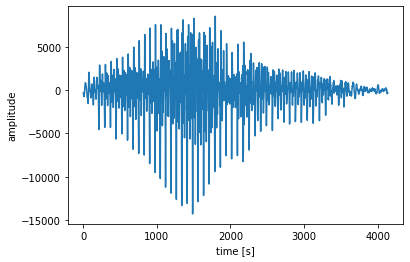

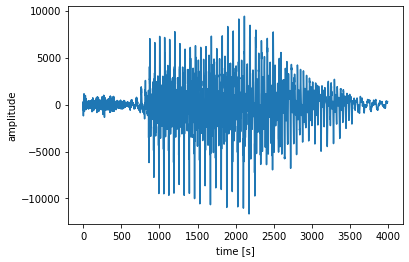

p
[0.00025063 0.         0.         0.00050125 0.00025063 0.00050125
 0.         0.         0.00025063 0.00075188 0.00125313 0.00075188
 0.00025063 0.00025063 0.00025063 0.00025063 0.         0.00075188
 0.00025063 0.00100251 0.00025063 0.00075188 0.00050125 0.00100251
 0.         0.00200501 0.00200501 0.00075188 0.00401003 0.
 0.00250627 0.00325815 0.00350877 0.00250627 0.0047619  0.00551378
 0.00651629 0.00601504 0.00551378 0.00877193 0.0085213  0.00676692
 0.01253133 0.01077694 0.01403509 0.01428571 0.03333333 0.
 0.01904762 0.0160401  0.01879699 0.02130326 0.03433584 0.05313283
 0.07017544 0.09473684 0.17568922 0.04085213 0.03258145 0.
 0.02807018 0.01879699 0.02305764 0.02130326 0.01779449 0.01578947
 0.01253133 0.01729323 0.01077694 0.0122807  0.0085213  0.01027569
 0.00776942 0.00676692 0.0047619  0.00451128 0.00426065 0.00325815
 0.00426065 0.00300752 0.00250627 0.00225564 0.00125313 0.00150376
 0.00225564 0.00125313 0.00150376 0.00150376 0.00075188 0.00175439
 0.00125313 0.   

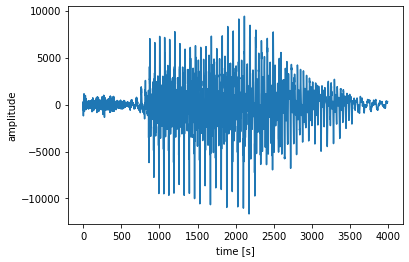

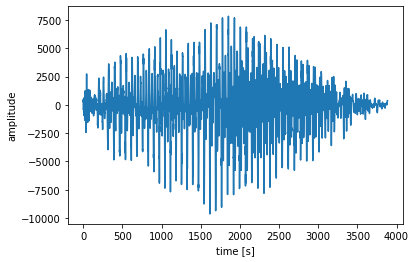

p
[0.00025733 0.         0.00025733 0.00025733 0.00025733 0.00051467
 0.00025733 0.00025733 0.000772   0.         0.001544   0.00051467
 0.000772   0.00205867 0.000772   0.001544   0.00205867 0.001544
 0.00102934 0.00102934 0.00102934 0.00102934 0.00257334 0.00308801
 0.001544   0.00257334 0.00102934 0.00411734 0.00772002 0.
 0.00540401 0.00669068 0.00643335 0.00488935 0.00566135 0.00463201
 0.00900669 0.00643335 0.00669068 0.00952136 0.00849202 0.0120947
 0.0120947  0.01158003 0.01183736 0.01389604 0.03448276 0.
 0.01569738 0.01981472 0.02727741 0.03396809 0.04400412 0.04863613
 0.04734946 0.06073083 0.09855893 0.04246011 0.03474009 0.
 0.02856408 0.02779207 0.01904272 0.02290273 0.02032939 0.01544004
 0.01827072 0.01646938 0.01466804 0.01569738 0.01441071 0.01003603
 0.01080803 0.00874936 0.00694802 0.00669068 0.00669068 0.00617602
 0.00514668 0.00334534 0.00617602 0.00437468 0.00386001 0.001544
 0.00231601 0.00386001 0.00257334 0.00283067 0.001544   0.00128667
 0.000772   0.00051467

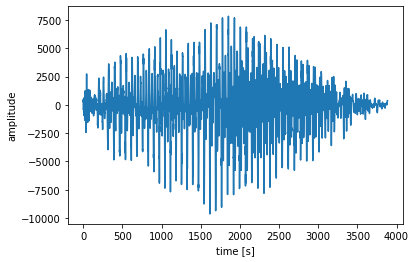

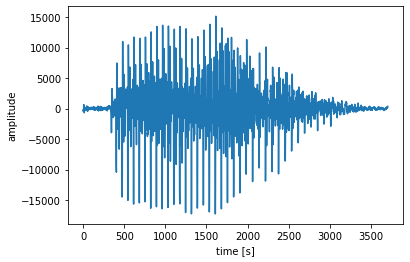

p
[0.00053937 0.00053937 0.         0.0021575  0.00080906 0.00161812
 0.00242718 0.00134844 0.00161812 0.00134844 0.00026969 0.00161812
 0.00107875 0.00080906 0.00053937 0.00134844 0.00080906 0.00080906
 0.00080906 0.00053937 0.00107875 0.00053937 0.         0.0021575
 0.00161812 0.00161812 0.00107875 0.00188781 0.00404531 0.
 0.00188781 0.00161812 0.00134844 0.00269687 0.00296656 0.00566343
 0.00512406 0.00404531 0.00566343 0.00593312 0.00512406 0.01186624
 0.00943905 0.01537217 0.01618123 0.01752967 0.04045307 0.
 0.02427184 0.02265372 0.02885653 0.03640777 0.06283711 0.17071197
 0.10868393 0.04314995 0.07524272 0.0231931  0.02184466 0.
 0.02427184 0.01860841 0.01564186 0.01645092 0.01429342 0.01240561
 0.00647249 0.00728155 0.00755124 0.00647249 0.00647249 0.0062028
 0.00404531 0.00431499 0.00404531 0.00458468 0.00161812 0.00188781
 0.00404531 0.00323625 0.00161812 0.00188781 0.00242718 0.00134844
 0.00269687 0.00134844 0.0021575  0.00161812 0.00026969 0.0021575
 0.00053937 0.000269

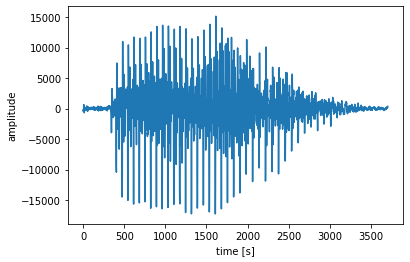

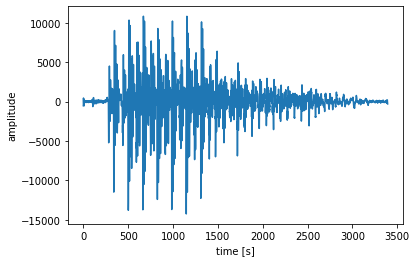

p
[2.94637596e-04 0.00000000e+00 8.83912787e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.89275192e-04 5.89275192e-04
 2.94637596e-04 0.00000000e+00 0.00000000e+00 8.83912787e-04
 0.00000000e+00 2.94637596e-04 2.94637596e-04 8.83912787e-04
 8.83912787e-04 2.94637596e-04 0.00000000e+00 2.94637596e-04
 5.89275192e-04 8.83912787e-04 5.89275192e-04 8.83912787e-04
 5.89275192e-04 5.89275192e-04 8.83912787e-04 1.76782557e-03
 4.12492634e-03 0.00000000e+00 1.47318798e-03 1.76782557e-03
 8.83912787e-04 3.24101355e-03 1.76782557e-03 3.24101355e-03
 4.12492634e-03 2.94637596e-03 2.65173836e-03 4.41956394e-03
 2.35710077e-03 3.24101355e-03 5.89275192e-03 4.41956394e-03
 5.59811432e-03 1.00176783e-02 1.23747790e-02 0.00000000e+00
 9.13376547e-03 1.59104302e-02 1.32586918e-02 1.94460813e-02
 1.88568061e-02 2.79905716e-02 3.83028874e-02 5.80436064e-02
 3.20860342e-01 8.19092516e-02 5.77489688e-02 0.00000000e+00
 4.94991161e-02 3.15262227e-02 2.62227460e-02 2.47495580e-02
 1.50265174e-02 9.7230

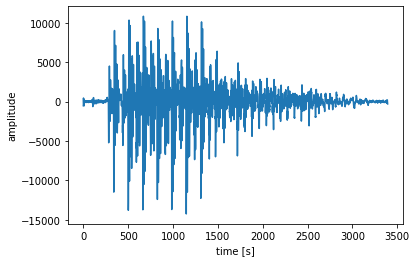

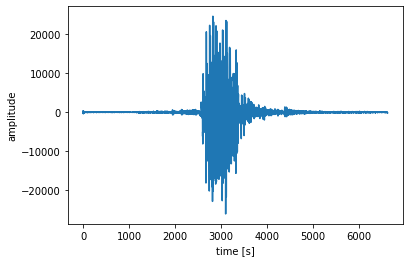

p
[1.50988978e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.50988978e-04 3.01977956e-04
 0.00000000e+00 1.50988978e-04 0.00000000e+00 3.01977956e-04
 1.50988978e-04 0.00000000e+00 1.50988978e-04 3.01977956e-04
 6.03955911e-04 3.01977956e-04 9.05933867e-04 9.05933867e-04
 1.05692284e-03 1.05692284e-03 9.05933867e-04 9.05933867e-04
 1.05692284e-03 9.05933867e-04 1.20791182e-03 1.66087876e-03
 2.11384569e-03 0.00000000e+00 1.96285671e-03 1.96285671e-03
 1.50988978e-03 1.35890080e-03 9.05933867e-04 1.81186773e-03
 1.05692284e-03 1.66087876e-03 2.71780160e-03 2.56681262e-03
 1.81186773e-03 2.41582364e-03 1.96285671e-03 2.56681262e-03
 2.86879058e-03 2.26483467e-03 1.04182395e-02 0.00000000e+00
 4.52966933e-03 1.10221954e-02 3.00468066e-02 5.28612411e-01
 2.73592028e-01 2.11384569e-02 1.14751623e-02 4.98263627e-03
 9.36131662e-03 4.22769138e-03 3.32175751e-03 0.00000000e+00
 2.26483467e-03 1.96285671e-03 2.86879058e-03 1.20791182e-03
 2.86879058e-03 1.5098

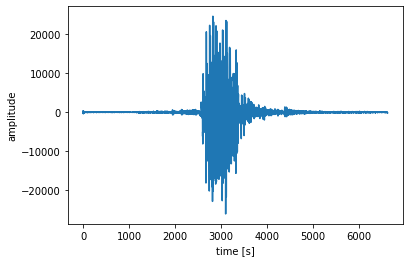

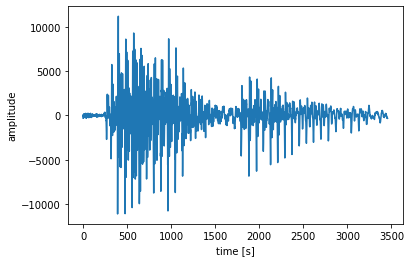

p
[0.00057854 0.         0.00028927 0.00028927 0.         0.00028927
 0.         0.         0.         0.         0.00028927 0.00115707
 0.00028927 0.00057854 0.00028927 0.         0.0008678  0.00028927
 0.00144634 0.00115707 0.0008678  0.00202488 0.00057854 0.00057854
 0.00144634 0.00144634 0.00231415 0.00202488 0.0072317  0.
 0.00318195 0.00318195 0.00491756 0.00404975 0.00433902 0.00549609
 0.00752097 0.00549609 0.0072317  0.00838878 0.00838878 0.01012439
 0.0127278  0.01938097 0.0190917  0.02834828 0.07578826 0.
 0.06132485 0.10384727 0.1371131  0.091698   0.07954874 0.06103558
 0.03934047 0.03442291 0.03962974 0.01388487 0.01099219 0.
 0.00896731 0.00665317 0.00954585 0.00462829 0.00404975 0.00520683
 0.00318195 0.00202488 0.00376049 0.00289268 0.00260341 0.00289268
 0.00173561 0.00202488 0.00115707 0.00144634 0.00144634 0.00115707
 0.00202488 0.00057854 0.00115707 0.00028927 0.00057854 0.00057854
 0.00057854 0.00028927 0.00028927 0.         0.00057854 0.00028927
 0.         0.   

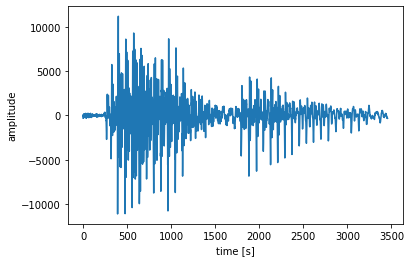

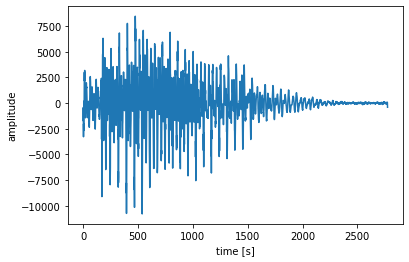

p
[0.00072046 0.         0.         0.00036023 0.         0.
 0.         0.         0.00036023 0.00036023 0.00036023 0.00036023
 0.00072046 0.00036023 0.00108069 0.00072046 0.00108069 0.00108069
 0.00108069 0.00144092 0.         0.00144092 0.00072046 0.00252161
 0.00216138 0.00216138 0.00144092 0.00108069 0.00576369 0.
 0.00252161 0.00144092 0.00432277 0.00432277 0.00216138 0.00288184
 0.00324207 0.004683   0.00756484 0.00540346 0.00540346 0.00504323
 0.00900576 0.00576369 0.00684438 0.00720461 0.01837176 0.
 0.01693084 0.01909222 0.02161383 0.0212536  0.0306196  0.03097983
 0.04142651 0.05943804 0.29178674 0.04755043 0.03097983 0.
 0.02521614 0.02881844 0.02413545 0.01909222 0.01260807 0.01837176
 0.01152738 0.01440922 0.01332853 0.01008646 0.00936599 0.00684438
 0.01332853 0.01188761 0.00612392 0.00576369 0.00576369 0.00360231
 0.00216138 0.00252161 0.00288184 0.00108069 0.00324207 0.00180115
 0.00288184 0.00072046 0.00108069 0.00108069 0.00072046 0.00072046
 0.00072046 0.00036023 0.

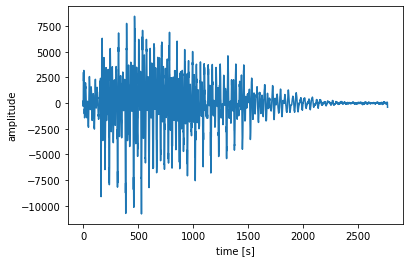

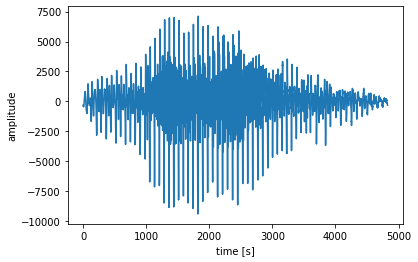

p
[0.00020717 0.         0.         0.00041434 0.00041434 0.00041434
 0.00124301 0.00041434 0.00041434 0.00082867 0.00103584 0.00041434
 0.0006215  0.00020717 0.00103584 0.00124301 0.0006215  0.00186451
 0.00124301 0.00145018 0.0006215  0.0006215  0.         0.00124301
 0.0006215  0.00103584 0.0006215  0.00103584 0.00207168 0.
 0.00165734 0.00227885 0.00227885 0.00352186 0.00248602 0.00372902
 0.0045577  0.00497203 0.0051792  0.00662938 0.00538637 0.00766522
 0.00766522 0.00787238 0.00890822 0.00911539 0.02216698 0.
 0.01346592 0.01698778 0.02092397 0.02962503 0.03148954 0.03169671
 0.04433395 0.04951316 0.12140046 0.07043712 0.051792   0.
 0.0511705  0.05096333 0.04329811 0.03480423 0.02506733 0.02838202
 0.02154547 0.01781645 0.02030247 0.01429459 0.01408742 0.00849389
 0.00787238 0.00766522 0.00704371 0.00683654 0.0051792  0.00310752
 0.00145018 0.00372902 0.00331469 0.00207168 0.00207168 0.00041434
 0.00124301 0.00103584 0.00041434 0.0006215  0.00103584 0.00020717
 0.00082867 0.000

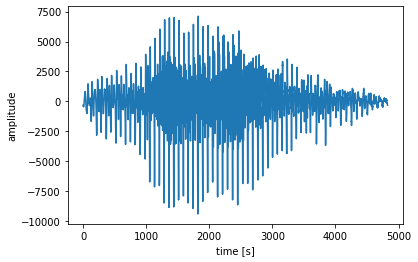

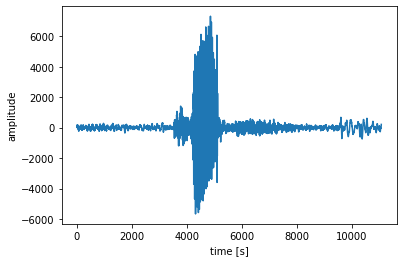

p
[9.02282775e-05 1.80456555e-04 9.02282775e-05 2.70684833e-04
 1.80456555e-04 0.00000000e+00 2.70684833e-04 2.70684833e-04
 5.41369665e-04 1.80456555e-04 7.21826220e-04 3.60913110e-04
 0.00000000e+00 4.51141388e-04 2.70684833e-04 4.51141388e-04
 6.31597943e-04 3.60913110e-04 5.41369665e-04 1.44365244e-03
 4.51141388e-04 8.12054498e-04 1.44365244e-03 1.26319589e-03
 1.44365244e-03 1.89479383e-03 8.12054498e-04 1.26319589e-03
 4.60164215e-03 0.00000000e+00 2.34593522e-03 1.62410900e-03
 2.07525038e-03 2.07525038e-03 1.80456555e-03 2.16547866e-03
 2.25570694e-03 3.87981593e-03 5.68438149e-03 8.75214292e-03
 1.52485789e-02 2.62564288e-02 8.47243526e-02 2.62564288e-01
 3.22024723e-01 1.32184427e-01 5.56708472e-02 0.00000000e+00
 9.38374086e-03 3.42867455e-03 2.61662005e-03 1.98502211e-03
 2.34593522e-03 1.53388072e-03 1.35342416e-03 1.44365244e-03
 2.79707660e-03 1.08273933e-03 2.25570694e-03 0.00000000e+00
 9.02282775e-04 1.26319589e-03 1.08273933e-03 6.31597943e-04
 5.41369665e-04 9.9251

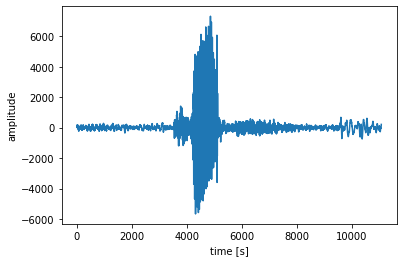

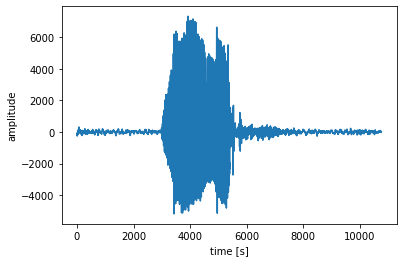

p
[2.78862242e-04 2.78862242e-04 2.78862242e-04 2.78862242e-04
 9.29540807e-05 9.29540807e-04 6.50678565e-04 1.95203569e-03
 1.48726529e-03 1.95203569e-03 1.85908161e-03 1.48726529e-03
 2.60271426e-03 2.60271426e-03 3.43930099e-03 3.34634690e-03
 4.74065811e-03 7.52928054e-03 5.57724484e-03 5.20542852e-03
 4.74065811e-03 3.53225507e-03 4.36884179e-03 3.43930099e-03
 4.92656628e-03 2.97453058e-03 3.25339282e-03 2.78862242e-03
 6.87860197e-03 0.00000000e+00 3.71816323e-03 2.69566834e-03
 3.16043874e-03 3.62520915e-03 4.36884179e-03 4.74065811e-03
 4.08997955e-03 4.64770403e-03 6.41383157e-03 1.39431121e-02
 6.30228667e-02 3.17159323e-01 3.20412716e-01 5.08458821e-02
 1.16192601e-02 5.94906116e-03 6.13496933e-03 0.00000000e+00
 2.97453058e-03 2.97453058e-03 4.08997955e-03 3.53225507e-03
 2.88157650e-03 2.50976018e-03 3.34634690e-03 2.69566834e-03
 5.48429076e-03 2.88157650e-03 3.34634690e-03 0.00000000e+00
 2.50976018e-03 2.41680610e-03 2.41680610e-03 3.34634690e-03
 1.67317345e-03 1.6731

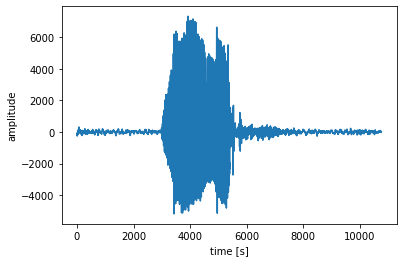

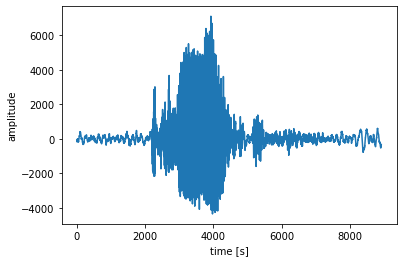

p
[1.12132765e-04 3.36398296e-04 6.72796591e-04 3.36398296e-04
 5.60663826e-04 1.45772595e-03 4.48531061e-04 1.12132765e-03
 2.57905360e-03 1.79412424e-03 1.68199148e-03 3.70038125e-03
 3.02758466e-03 3.92464678e-03 2.24265530e-03 3.25185019e-03
 2.57905360e-03 3.47611572e-03 3.47611572e-03 2.69118636e-03
 2.91545190e-03 3.36398296e-03 3.92464678e-03 3.70038125e-03
 4.93384167e-03 3.36398296e-03 4.70957614e-03 5.38237273e-03
 1.05404799e-02 0.00000000e+00 7.51289527e-03 9.86768334e-03
 1.26710025e-02 1.52500561e-02 2.02960305e-02 4.45167078e-02
 8.51087688e-02 1.53061224e-01 1.65844360e-01 1.42520745e-01
 8.46602377e-02 3.87979368e-02 2.72482619e-02 1.23346042e-02
 9.08275398e-03 8.74635569e-03 1.35680646e-02 0.00000000e+00
 5.83090379e-03 6.39156762e-03 4.14891231e-03 3.13971743e-03
 2.46692083e-03 2.24265530e-03 1.79412424e-03 1.79412424e-03
 4.26104508e-03 2.57905360e-03 2.01838977e-03 0.00000000e+00
 2.01838977e-03 1.68199148e-03 2.57905360e-03 1.90625701e-03
 1.34559318e-03 1.4577

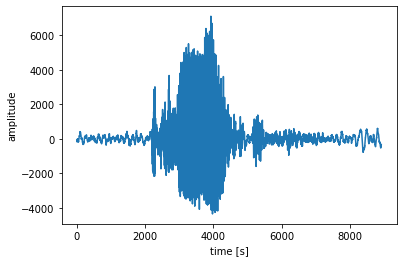

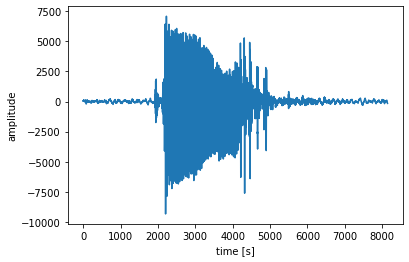

p
[1.22729504e-04 1.22729504e-04 0.00000000e+00 0.00000000e+00
 1.22729504e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.45459008e-04 1.22729504e-04 0.00000000e+00
 2.45459008e-04 2.45459008e-04 1.22729504e-04 4.90918017e-04
 7.36377025e-04 8.59106529e-04 1.35002455e-03 1.22729504e-03
 1.84094256e-03 1.96367207e-03 1.35002455e-03 1.22729504e-03
 1.10456554e-03 1.47275405e-03 1.10456554e-03 1.59548355e-03
 4.54099165e-03 0.00000000e+00 2.57731959e-03 2.94550810e-03
 3.68188513e-03 3.19096711e-03 1.71821306e-03 2.57731959e-03
 2.20913108e-03 2.82277860e-03 3.06823760e-03 2.20913108e-03
 2.20913108e-03 1.59548355e-03 3.06823760e-03 2.94550810e-03
 3.43642612e-03 2.82277860e-03 6.87285223e-03 0.00000000e+00
 3.43642612e-03 3.92734413e-03 4.54099165e-03 7.48649975e-03
 4.41826215e-03 1.00638193e-02 1.36229750e-02 2.66323024e-02
 5.32768778e-01 1.22115857e-01 2.62641139e-02 0.00000000e+00
 2.03730977e-02 1.85321551e-02 1.35002455e-02 1.22729504e-02
 1.12911144e-02 1.3500

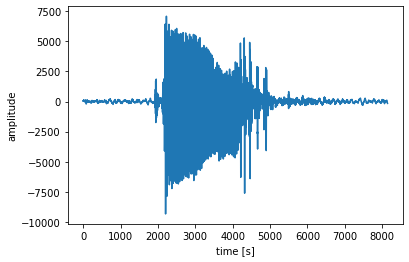

In [111]:
def join_features(mfcc, fbank):
    features = np.concatenate((mfcc, fbank), axis=1)
    return features

features = []
labels = []

def normalize(signal):
    result = signal.copy().astype('float64')
    xmin = np.min(result)
    xmax = np.max(result)
    for i in range(0, signal.size):
        result[i] = (result[i] - xmin) / (xmax - xmin)
        result[i] = "%.2f" % result[i]
    
    return result

def calculate_normalized_entropy(signal):
    #normalize
    signal = normalize(signal)
    
    p = np.zeros(101)
    for i in range(0, signal.size):
        p[(signal[i] / 0.01).astype('int64')] += 1
    
    p = p / signal.size
    print("p")
    print(p)
    max_entro = 0.0
    min_entro = 1.0
    entropy = np.zeros(signal.size)
    
    for i in range(0, signal.size):
        index = (signal[i] / 0.01).astype('int64')
        entropy[i] = -p[index]*math.log(p[index])
        max_entro = max(max_entro, p[index])
        min_entro = min(min_entro, p[index])
        
    for i in range(0,100):
        if p[i] == 0:
            continue
        #print(-p[i]*math.log(p[i]))
        
    lamb = (max_entro - min_entro) / 2.0
    return entropy, lamb
    
    
def read_file(files, label):
    for file in files:
        (rate,sig) = wav.read(file)
        
        snd = parselmouth.Sound(file)
    
        plt.figure()
        plt.plot(sig)
        plt.xlabel("time [s]")
        plt.ylabel("amplitude")
        plt.show()
        
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        features.append(acoustic_features)
        labels.append(label)
        
        entropy, lamb = calculate_normalized_entropy(sig)
        print("lamb")
        print(lamb)
        print("entropy")
        print(entropy)
        start_point = 0
        for i in range(0, entropy.size):
            print(entropy[i])
            if entropy[i] > lamb:
                start_point = i
                break
        print(start_point)
        sig = sig[start_point:]
        
        plt.figure()
        plt.plot(sig)
        plt.xlabel("time [s]")
        plt.ylabel("amplitude")
        plt.show()
        break
        
feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine", "plus", "minus", "times", "over"]

for i in feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob( os.path.join(os.getcwd(), '*.wav') )
    read_file(files, i)

In [14]:
print(features[1].size)
print(features[2].size)

2028
2613
